# VPoser

In [1]:
# Set up environment
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
# %matplotlib inline

from pathlib import Path
import numpy as np
import torch
from tinyhumans.models import SMPLX, VPoser

from tinyhumans.renderer import PyRenderer
from tinyhumans.tools import image_grid, plot_meshes

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)  # "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
# This tutorial requires 'vposer_v2_05'
support_dir = Path("..", "downloads")
vposer_pretrained_model_path = support_dir / "models" / "vposer" / "model.ckpt"
smplx_pretrained_model_path = support_dir / "models" / "smplx" / "SMPLX_NEUTRAL.npz"
# smplx_pretrained_model_path = support_dir / "SMPLX_NEUTRAL_2020.npz" # same as the other + FLAME face model values are non zero
sample_amass_fname = support_dir / "amass_sample.npz"  # a sample npz file from AMASS

In [3]:
# Load SMPLX and VPoser Model
smplx_model = SMPLX.from_pretrained(pretrained_model_path=smplx_pretrained_model_path, num_betas=10, device_map=device)
vposer = VPoser.from_pretrained(
    vposer_pretrained_model_path,
    remove_key_prefix="vp_model.",
    replace_key_prefixes={"encoder_net.8.mu.": "mu_layer.", "encoder_net.8.logvar.": "logvar_layer."},
    device_map=device,
)

## Encoding a body_pose (pose>poZ)
We will load an [AMASS](http://amass.is.tue.mpg.de/) sample and place the body pose on the right device for batch processing. To learn more on AMASS data loading refer to [link](https://github.com/nghorbani/amass/blob/master/notebooks/01-AMASS_Visualization.ipynb).

In [4]:
# Prepare the pose_body from amass sample
amass_body_pose = np.load(sample_amass_fname)["poses"][:, 3:66]
amass_body_pose = torch.from_numpy(amass_body_pose).type(torch.float).to(device)
print("amass_body_pose.shape", amass_body_pose.shape)

amass_body_pose.shape torch.Size([500, 63])


In [5]:
amass_body_poZ = vposer.encode(amass_body_pose).mean
print("amass_body_poZ.shape", amass_body_poZ.shape)

amass_body_poZ.shape torch.Size([500, 32])


## Decoding a body_poZ (poZ>pose)
We will decode the same poZ in order to reconstruct the pose and will visualize it for a random frame.

In [6]:
amass_body_pose_rec = vposer.decode(amass_body_poZ)["pose_axis_angles"].contiguous().contiguous().flatten(-2)
print("amass_body_pose_rec.shape", amass_body_poZ.shape)

amass_body_pose_rec.shape torch.Size([500, 32])


In [7]:
##Let's visualize the original pose and the reconstructed one:
t = np.random.choice(len(amass_body_pose))

all_pose_body = torch.stack([amass_body_pose[t], amass_body_pose_rec[t]])

all_pose_body.shape

torch.Size([2, 63])

In [ ]:
betas = torch.randn([2, 10], dtype=torch.float32).to("mps")
smplx_output = smplx_model(poses={"body": all_pose_body}, shape_components={"betas": betas}).cpu()
smplx_meshes = smplx_output.get_meshes(smplx_model.faces)
fig = plot_meshes(smplx_meshes, join=True, show=True, subplot_size=800, subplot_titles=None)

In [9]:
renderer = PyRenderer(
    image_size=(600, 600),
    bg_color=(0.99, 0.99, 0.99),
    ambient_light=(0.5, 0.5, 0.5),
    use_raymond_lighting=True,
    use_direct_lighting=False,
    camera_params={"translation": [0.0, -0.4, 2.5], "rotation": np.eye(3), "focal_length": 600},
)

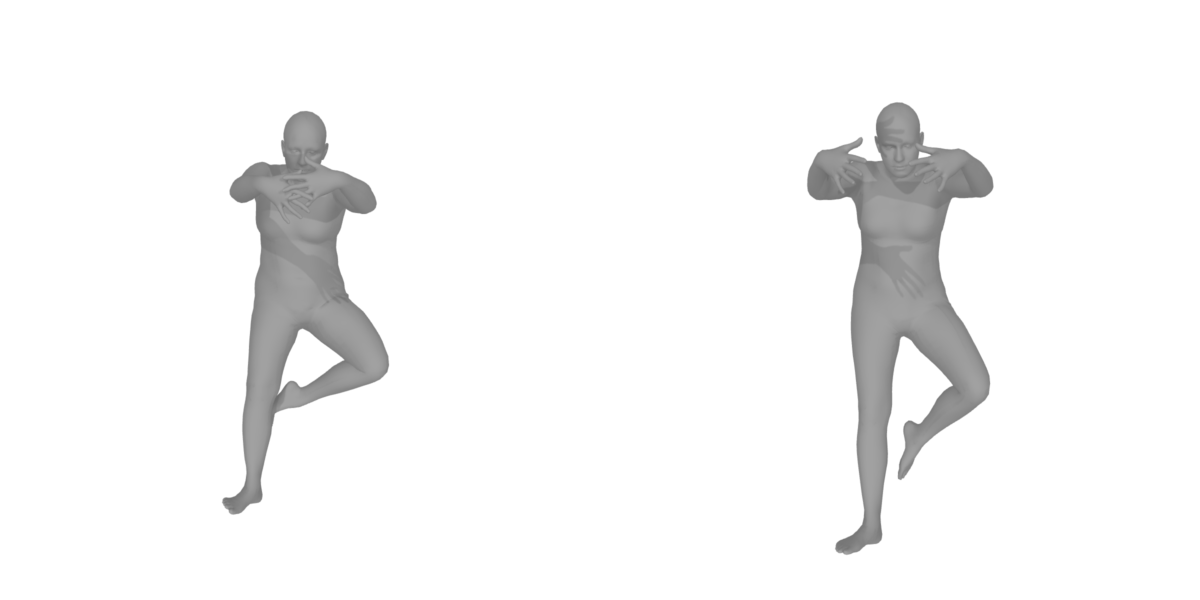

In [10]:
images = [
    renderer(
        mesh,
        render_params={
            "render_face_normals": False,
            "render_in_RGBA": False,
            "render_segmentation": False,
            "render_shadows": True,
            "render_vertex_normals": False,
            "render_wireframe": False,
            "skip_cull_faces": False,
        },
    )
    for mesh in smplx_meshes
]

image_grid([image[0] for image in images], rows=1, cols=len(images))

The closer above two bodies look similar to each other, the more successful is VPoser is in reconstructing the original data space body pose parameters.

## Generate novel body poses

poZ_body_sample.shape torch.Size([1, 32])
pose_body.shape torch.Size([1, 63])


/Users/abenetatos/GitRepos/tinyhumans/.venv/lib/python3.11/site-packages/tensordict/tensorclass.py:1616: UserWarning:

The method <bound method TensorDictBase._set_device of TensorDict(
    fields={
    },
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False)> wasn't explicitly implemented for tensorclass. This fallback will be deprecated in future releases because it is inefficient and non-compilable. Please raise an issue in tensordict repo to support this method!



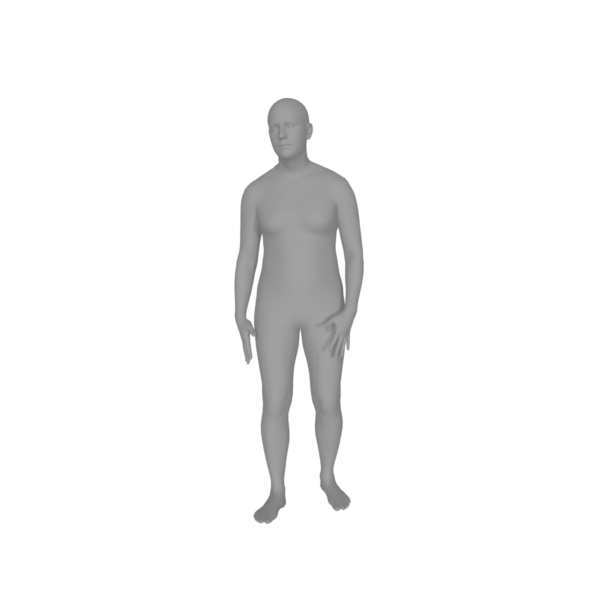

In [12]:
# Sample a 32 dimensional vector from a Normal distribution
poZ_body_sample = torch.from_numpy(np.random.randn(1, 32).astype(np.float32)).to(device)
pose_body = vposer.decode(poZ_body_sample)["pose_axis_angles"].contiguous().view(-1, 63)

print("poZ_body_sample.shape", poZ_body_sample.shape)
print("pose_body.shape", pose_body.shape)

smplx_output = smplx_model(poses={"body": pose_body}).cpu()
smplx_meshes = smplx_output.get_meshes(smplx_model.faces)

images = [
    renderer(
        mesh,
        render_params={
            "render_face_normals": False,
            "render_in_RGBA": False,
            "render_segmentation": False,
            "render_shadows": True,
            "render_vertex_normals": False,
            "render_wireframe": False,
            "skip_cull_faces": False,
        },
    )
    for mesh in smplx_meshes
]

images[0][0]

Above we drawn a sample from a 32 dimensional Normal distribution and decoded its value to a full 63 dimensional SMPL body pose vector. The generated image shows the corresponding rendered body. Fo an advanced tutorial on generating poses with VPoser refer to [Link](notebooks/vposer_sampling.ipynb).